In [1]:
# Clustering the pixels based on RGB color
#

In [2]:
# imports
#
import sys
import os
import glob
import time
import numpy as np
import scipy as sp
from scipy import ndimage, spatial
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import *
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

In [3]:
# Globals
#
# br = breakpoint
br = set_trace
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6

In [4]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.uint32(img)/255
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

def balance_dataset(fts, tgs):
    """
    This function only works for binary targets.
    It tries to randomly sample the features with 0 targets to make the 
    dataset balanced.
    """
    posfts = fts[tgs == 1, :]
    negfts = fts[tgs == 0, :]
    negfts = negfts[np.random.choice(range(negfts.shape[0]), 
                                     posfts.shape[0],
                                     replace=False), :]
    # concatenate and shuffle
    selfts = np.vstack((negfts, posfts))
    seltgs = np.hstack((np.zeros(negfts.shape[0]), np.ones(posfts.shape[0])))
    random_indices = np.arange(selfts.shape[0])
    np.random.shuffle(random_indices)
    selfts = selfts[random_indices, :]
    seltgs = seltgs[random_indices]
    return selfts, seltgs
    


In [241]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath, rescale=False)
train_masks = np.int64(read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath, rescale=False)
test_masks = np.int64(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)

(80, 512, 512, 3) (80, 512, 512) (20, 512, 512, 3) (20, 512, 512)


In [251]:
# extract color features
cfeats = np.int64(train_images.reshape((train_images.shape[0]*train_images.shape[1]*train_images.shape[2], 3)))#[:512*512, :]
print(cfeats.shape)
ctargs = train_masks.reshape((train_masks.shape[0]*train_masks.shape[1]*train_masks.shape[2], -1))#[:512*512, :]
print(ctargs.shape)
print(np.unique(cfeats, axis=0).shape)

(20971520, 3)
(20971520, 1)
(559089, 3)


In [252]:
# find unique (R, G, B, zero_count, one_count, one_probability)
uf0, ufc0 = np.unique(cfeats[ctargs[:, 0] == 0, :],
                            return_counts=True, axis=0)
uf1, ufc1 = np.unique(cfeats[ctargs[:, 0] == 1, :],
                            return_counts=True, axis=0)
print(len(ufc0), len(ufc1))

counts = np.zeros((6, 256, 256, 256))
counts[:3, :, :, :] = np.mgrid[0:256, 0:256, 0:256]
counts[3, uf0[:, 0], uf0[:, 1], uf0[:, 2]] = ufc0
counts[4, uf1[:, 0], uf1[:, 1], uf1[:, 2]] = ufc1
counts[5, :, :, :] = counts[4, :, :, :] / (counts[3, :, :, :] +
                                           counts[4, :, :, :] + EPSILON)
print(counts.shape)
counts2d = counts.reshape((6, 256*256*256)).T
counts2d = counts2d[counts2d[:, 3:].sum(axis=1) > EPSILON]
print(counts2d.shape)

495914 312155
(6, 256, 256, 256)
(559089, 6)


In [253]:
np.all(counts2d[:, :3] == cfeats[100000, :], axis=1).sum()

1

In [254]:
cfeats[100000, :], ctargs[100000, :]

(array([250, 132,  82]), array([0]))

In [255]:
counts[:, 250, 132, 82]

array([2.50000000e+02, 1.32000000e+02, 8.20000000e+01, 2.60000000e+01,
       6.00000000e+00, 1.87499994e-01])

In [256]:
# use K-Means (k == 1)
feats, targs = counts2d[:, :3], 1*(counts2d[:, 5]>0.5)
km1 = sklearn.neighbors.KNeighborsClassifier(
    n_neighbors=1, p=2, metric='minkowski').fit(feats, targs)

0.9006233215332031 0.19045991298943443


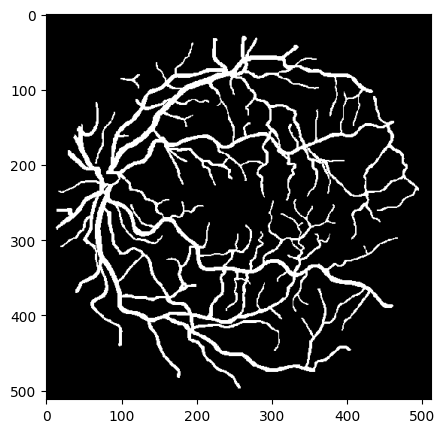

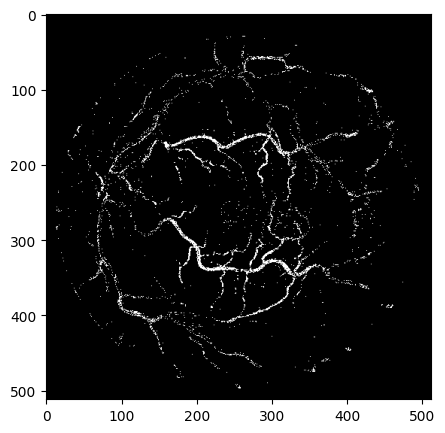

In [259]:
# try an image
n = 70
image, mask = train_images[n:n+1, :, :, :], train_masks[n, :, :]
# image, mask = test_images[n, :, :, :], test_masks[n, :, :]
ft = np.int64(image.reshape((image.shape[0]*image.shape[1]*image.shape[2],
                             3)))
ac = mask.reshape((mask.shape[0]*mask.shape[1], ))
pr = km1.predict(ft)
pmask = pr.reshape(mask.shape)
# show(image[0, :, :, :])
show(mask)
show(pmask)
print(sklearn.metrics.accuracy_score(ac, pr),
      sklearn.metrics.jaccard_score(ac, pr))

In [260]:
ft[ac != pr, :]

array([[145,  50,  23],
       [151,  74,  27],
       [159,  84,  38],
       ...,
       [132, 107,  61],
       [133, 109,  62],
       [ 79,   4,   1]])

In [261]:
targs[np.all(feats == ft[ac != pr, :][0, :], axis=1)]

array([1])

In [262]:
counts2d[np.all(feats == ft[ac != pr, :][0, :], axis=1)]

array([[145.        ,  50.        ,  23.        ,   4.        ,
          7.        ,   0.63636358]])

In [263]:
ctargs[np.all(cfeats == ft[ac != pr, :][0, :], axis=1)]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [278]:
img0 = counts2d[:, 4][counts2d[:, 4] < 0.5]
img0 = img0.reshape((img0.shape[0]/100, -1))
show(img0)

TypeError: 'float' object cannot be interpreted as an integer

In [281]:
np.float64(img0.shape) / 2

array([123467.])

In [ ]:
jaccard = sklearn.metrics.jaccard_score(tg, pr)
dice = 2 * jaccard / (jaccard + 1)
print(jaccard, dice)

0.46654288729052723 0.6362485425195799


In [ ]:
intersection = (tg * pr).sum()
dice = 2*intersection / (tg.sum() + pr.sum())
print(dice)

0.6362485425195799


In [12]:
ft.shape

(262144, 3)

In [16]:
(ac != pr).sum()

34871

In [36]:
x = np.random.randint(0, 10, (3, 3))
x

array([[8, 2, 2],
       [4, 2, 3],
       [9, 5, 6]])

In [38]:
x[[0, 1, 0], [1, 2, 1]] = 11
x

array([[ 8, 11,  2],
       [ 4,  2, 11],
       [ 9,  5,  6]])

In [169]:
x = np.zeros((4, 4, 4, 3))

In [170]:
x[:, :, :, :] = np.mgrid[0:4, 0:4, 0:4].T

In [171]:
x[1, 2, 3, :]

array([3., 2., 1.])

True

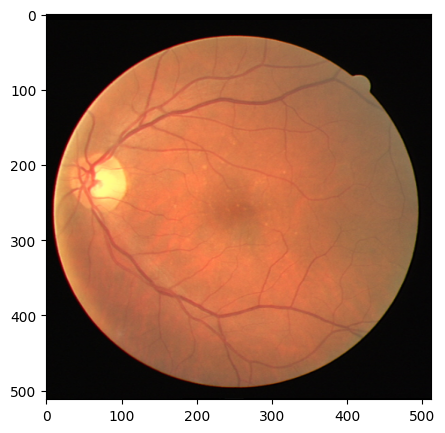

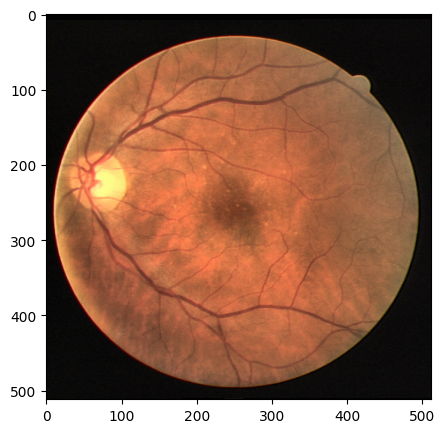

In [293]:
img0 = train_images[0, :, :, :]
show(img0)
img0c = skimage.exposure.equalize_adapthist(img0, kernel_size=None, clip_limit=0.01, nbins=256)
show(img0c)

True

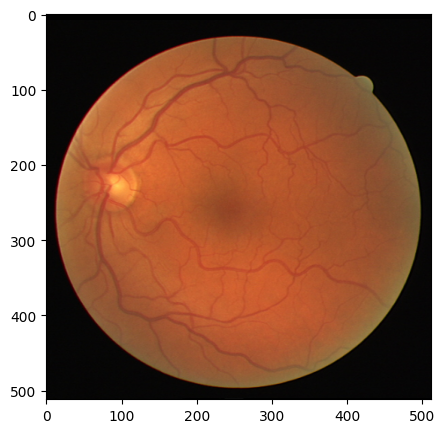

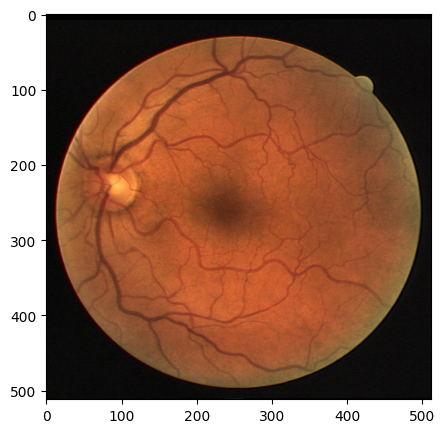

In [302]:
img70 = train_images[70, :, :, :]
show(img70)
img70c = skimage.exposure.equalize_adapthist(img70, kernel_size=None, clip_limit=0.01, nbins=256)
show(img70c)

True

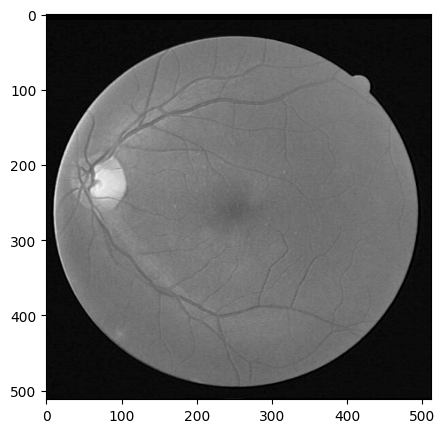

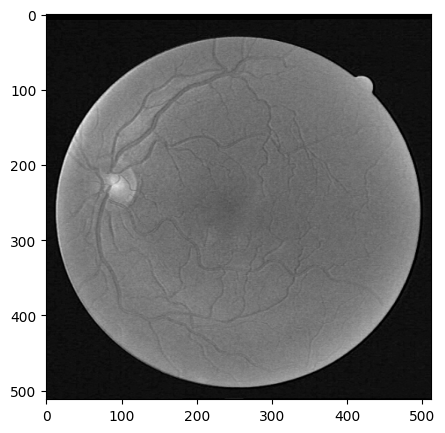

In [288]:
show(train_images[0, :, :, 2])
show(train_images[70, :, :, 2])